In [1]:
import numpy as np

import cartopy.crs as crs
from netCDF4 import Dataset
import xarray as xr
from scipy.interpolate import griddata
from sklearn.cluster import KMeans

from cartopy.feature import NaturalEarthFeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter,
                                LatitudeLocator, LongitudeLocator)

import matplotlib.ticker as mticker
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap, ScalarMappable
from matplotlib.colors import Normalize

states = NaturalEarthFeature(category="cultural", scale="50m",
                             facecolor="none",
                             name="admin_0_boundary_lines_land")
cart_proj = crs.PlateCarree()

In [2]:
def data_importer():
    fname = "../data/SCS/CMEMS_chl.nc"
    chl_data = xr.open_dataset(fname)

    fname = "../data/SCS/CMEMS_temp.nc"
    temp_data = xr.open_dataset(fname)
    
    fname = "../data/SCS/bathymetry.nc"
    bath = xr.open_dataset(fname)
    
    return chl_data, temp_data, bath

def data_extractor(date="all"):
    """ Returns chlorophyll, sst and bathymetry interpolated to the
    larger grid (for this dataset, temperature) """
    
    chl_data, temp_data, bath = data_importer()
    if date == "all":
        chl = chl_data.CHL
        temp = temp_data.analysed_sst
    
    else: 
        chl = chl_data.sel(time=date).CHL
        temp = temp_data.sel(time=date).analysed_sst
        
    lons = temp.lon.to_numpy()
    lats = temp.lat.to_numpy()
    temp = temp.to_numpy()[0]
    chl = chl.interp(lon = lons, lat = lats, method = "nearest").to_numpy()
    bath = bath.elevation.interp(lon = lons, lat = lats, method = "nearest").to_numpy()
    bath[np.isnan(bath)] = 0
    
    return lons, lats, chl, temp, bath

def bathymetry_filter(chl, temp, h = -1000):
    """ Removes coastal data (depth > -1000 m)"""
    
    chl_filt = np.copy(chl)
    chl_filt[elevation >= h] = np.nan
    
    temp_filt = np.copy(temp)
    temp_filt[elevation >= h] = np.nan
    return chl_filt, temp_filt

def anomalies(chl, temp):
    return (chl - np.nanmean(chl))/np.nanstd(chl), (temp - np.nanmean(temp))/np.nanstd(temp)

def cluster_data(chl, temp):
    data = np.array(list(zip(chl[~np.isnan(chl)], temp[~np.isnan(chl)])))
    kmeans = KMeans(n_clusters = 2, init = "random")
    labels = kmeans.fit_predict(data)
    return labels

def labels_matrix(labels):
    labels_matrix = np.empty(np.shape(chl_filt))
    labels_matrix[:,:] = np.nan
    mask = ~np.isnan(chl_norm)
    labels_matrix[mask] = labels.astype(int)
    return labels_matrix

In [3]:
lons, lats, chl, temp, bath = data_extractor("2005-05-17")

In [4]:
chl, temp = bathymetry_filter(chl, temp)

chl_norm, temp_norm = anomalies(chl, temp)

labels = cluster_data(chl_norm, temp_norm)
labels_matrix = labels_matrix(labels)

NameError: name 'elevation' is not defined

In [ ]:
## Clorofilla regriddata con temperatura - Prova di visualizzazione ##

fig = plt.figure(figsize = [7,7])
ax = plt.axes(projection=cart_proj)

ax.add_feature(states, linewidth=.5, edgecolor="black")
ax.coastlines('50m', linewidth=0.8)

colormap = plt.get_cmap("winter", 20) #or any other colormap
normalize = Normalize(vmin=0.0, vmax=0.15)


plt.contourf(lons, lats, chl,
             transform=crs.PlateCarree(),
             cmap=colormap, norm=normalize)

ax.tick_params(axis = "both", direction = "in", labelsize = 12, length = 5)
ax.set_xticks(np.arange(108,115,2), crs=crs.PlateCarree())
ax.set_yticks(np.arange(10,20,2), crs=crs.PlateCarree())
ax.xaxis.set_major_formatter(LONGITUDE_FORMATTER)
ax.yaxis.set_major_formatter(LATITUDE_FORMATTER)


ax.set_ylim([9,19])
ax.set_xlim([108,114])

cbar = plt.colorbar(ScalarMappable(norm=normalize, cmap=colormap), ax=ax, shrink=.98)
cbar.set_label(label = "Chlorophyll concentration [mg m$^{-3}$]", fontsize = 15)

## Rimozione batimetria

In [5]:
bath =  xr.open_dataset("../data/SCS/bathymetry.nc")

In [6]:
#Uniformazione della batimetria con la griglia meno fitta (temperatura)
elevation = bath.elevation.interp(lon = lons, lat = lats, method = "nearest").to_numpy()

In [7]:
elevation[np.isnan(elevation)] = 0
elevation

array([[    0.,   -59.,   -59., ..., -1823., -1787., -1611.],
       [    0.,   -64.,   -59., ..., -2117., -2058., -1908.],
       [    0.,   -63.,   -63., ..., -2011., -2074., -2152.],
       ...,
       [    0.,   -60.,   -55., ..., -1071., -1318., -1399.],
       [    0.,   -67.,   -57., ...,  -981., -1023., -1057.],
       [    0.,     0.,     0., ...,     0.,     0.,     0.]])

In [8]:
print(elevation.shape, chl.shape, temp.shape)

(201, 121) (201, 121) (201, 121)


In [9]:
# Maschera per mantenere solo i valori di chl e temp solo dove la batimetria è < -1000 m

chl_filt = np.copy(chl)
chl_filt[elevation >= -1000] = np.nan

temp_filt = np.copy(temp)
temp_filt[elevation >= -1000] = np.nan

In [10]:
print(chl_filt.shape, temp_filt.shape)

(201, 121) (201, 121)


In [11]:
# Qui rimuoviamo solo la media 
chl_norm = chl_filt - np.nanmean(chl_filt)
temp_norm = temp_filt - np.nanmean(temp_filt)

In [12]:
print(chl_norm.shape, temp_norm.shape)

(201, 121) (201, 121)


In [13]:
# Preparazione dei dati per clustering (KMeans non accetta NaN e il profilo di chl
# non è uniforme a causa della presenza di nubi)
data = np.array(list(zip(chl_norm[~np.isnan(chl_norm)], temp_norm[~np.isnan(chl_norm)])))

In [14]:
kmeans = KMeans(n_clusters = 15, init = "random")
labels = kmeans.fit_predict(data)

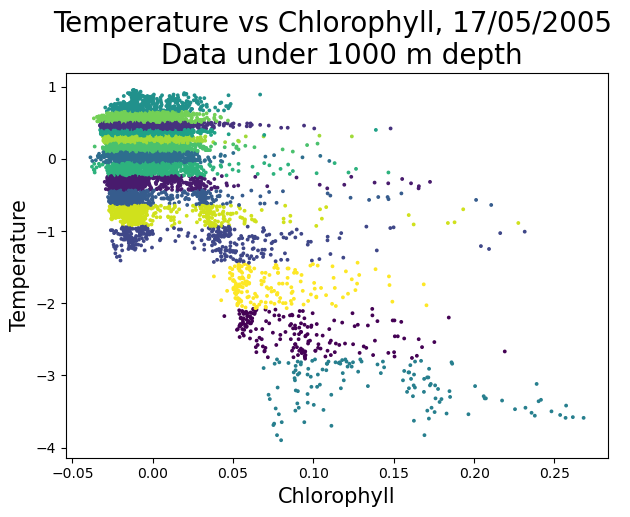

In [15]:
plt.figure(figsize = [7,5])
plt.scatter(data[:,0], data[:,1], s = 3, c = labels)
plt.xlabel("Chlorophyll", fontsize = 15)
plt.ylabel("Temperature", fontsize = 15)
plt.title("Temperature vs Chlorophyll, 17/05/2005 \n Data under 1000 m depth", fontsize = 20)

plt.savefig("../immagini/SCS/temp_chl_cluster_onlymean.pdf", bbox_inches = "tight")

Il clustering avviene su strisce uniformi perché le dimensioni non sono normalizzate; le distanze sull'asse della clorofilla sono di due ordini di grandezza minore rispetto alla temperatura. Proviamo a standardizzare tutto.

In [16]:
chl_filt = np.copy(chl)
chl_filt[elevation >= -1000] = np.nan

temp_filt = np.copy(temp)
temp_filt[elevation >= -1000] = np.nan

In [17]:
chl_norm = (chl_filt - np.nanmean(chl_filt))/np.nanstd(chl_filt)
temp_norm = (temp_filt - np.nanmean(temp_filt))/np.nanstd(temp_filt)

In [18]:
print(chl_norm.shape, temp_norm.shape)

(201, 121) (201, 121)


In [19]:
data = np.array(list(zip(chl_norm[~np.isnan(chl_norm)], temp_norm[~np.isnan(chl_norm)])))

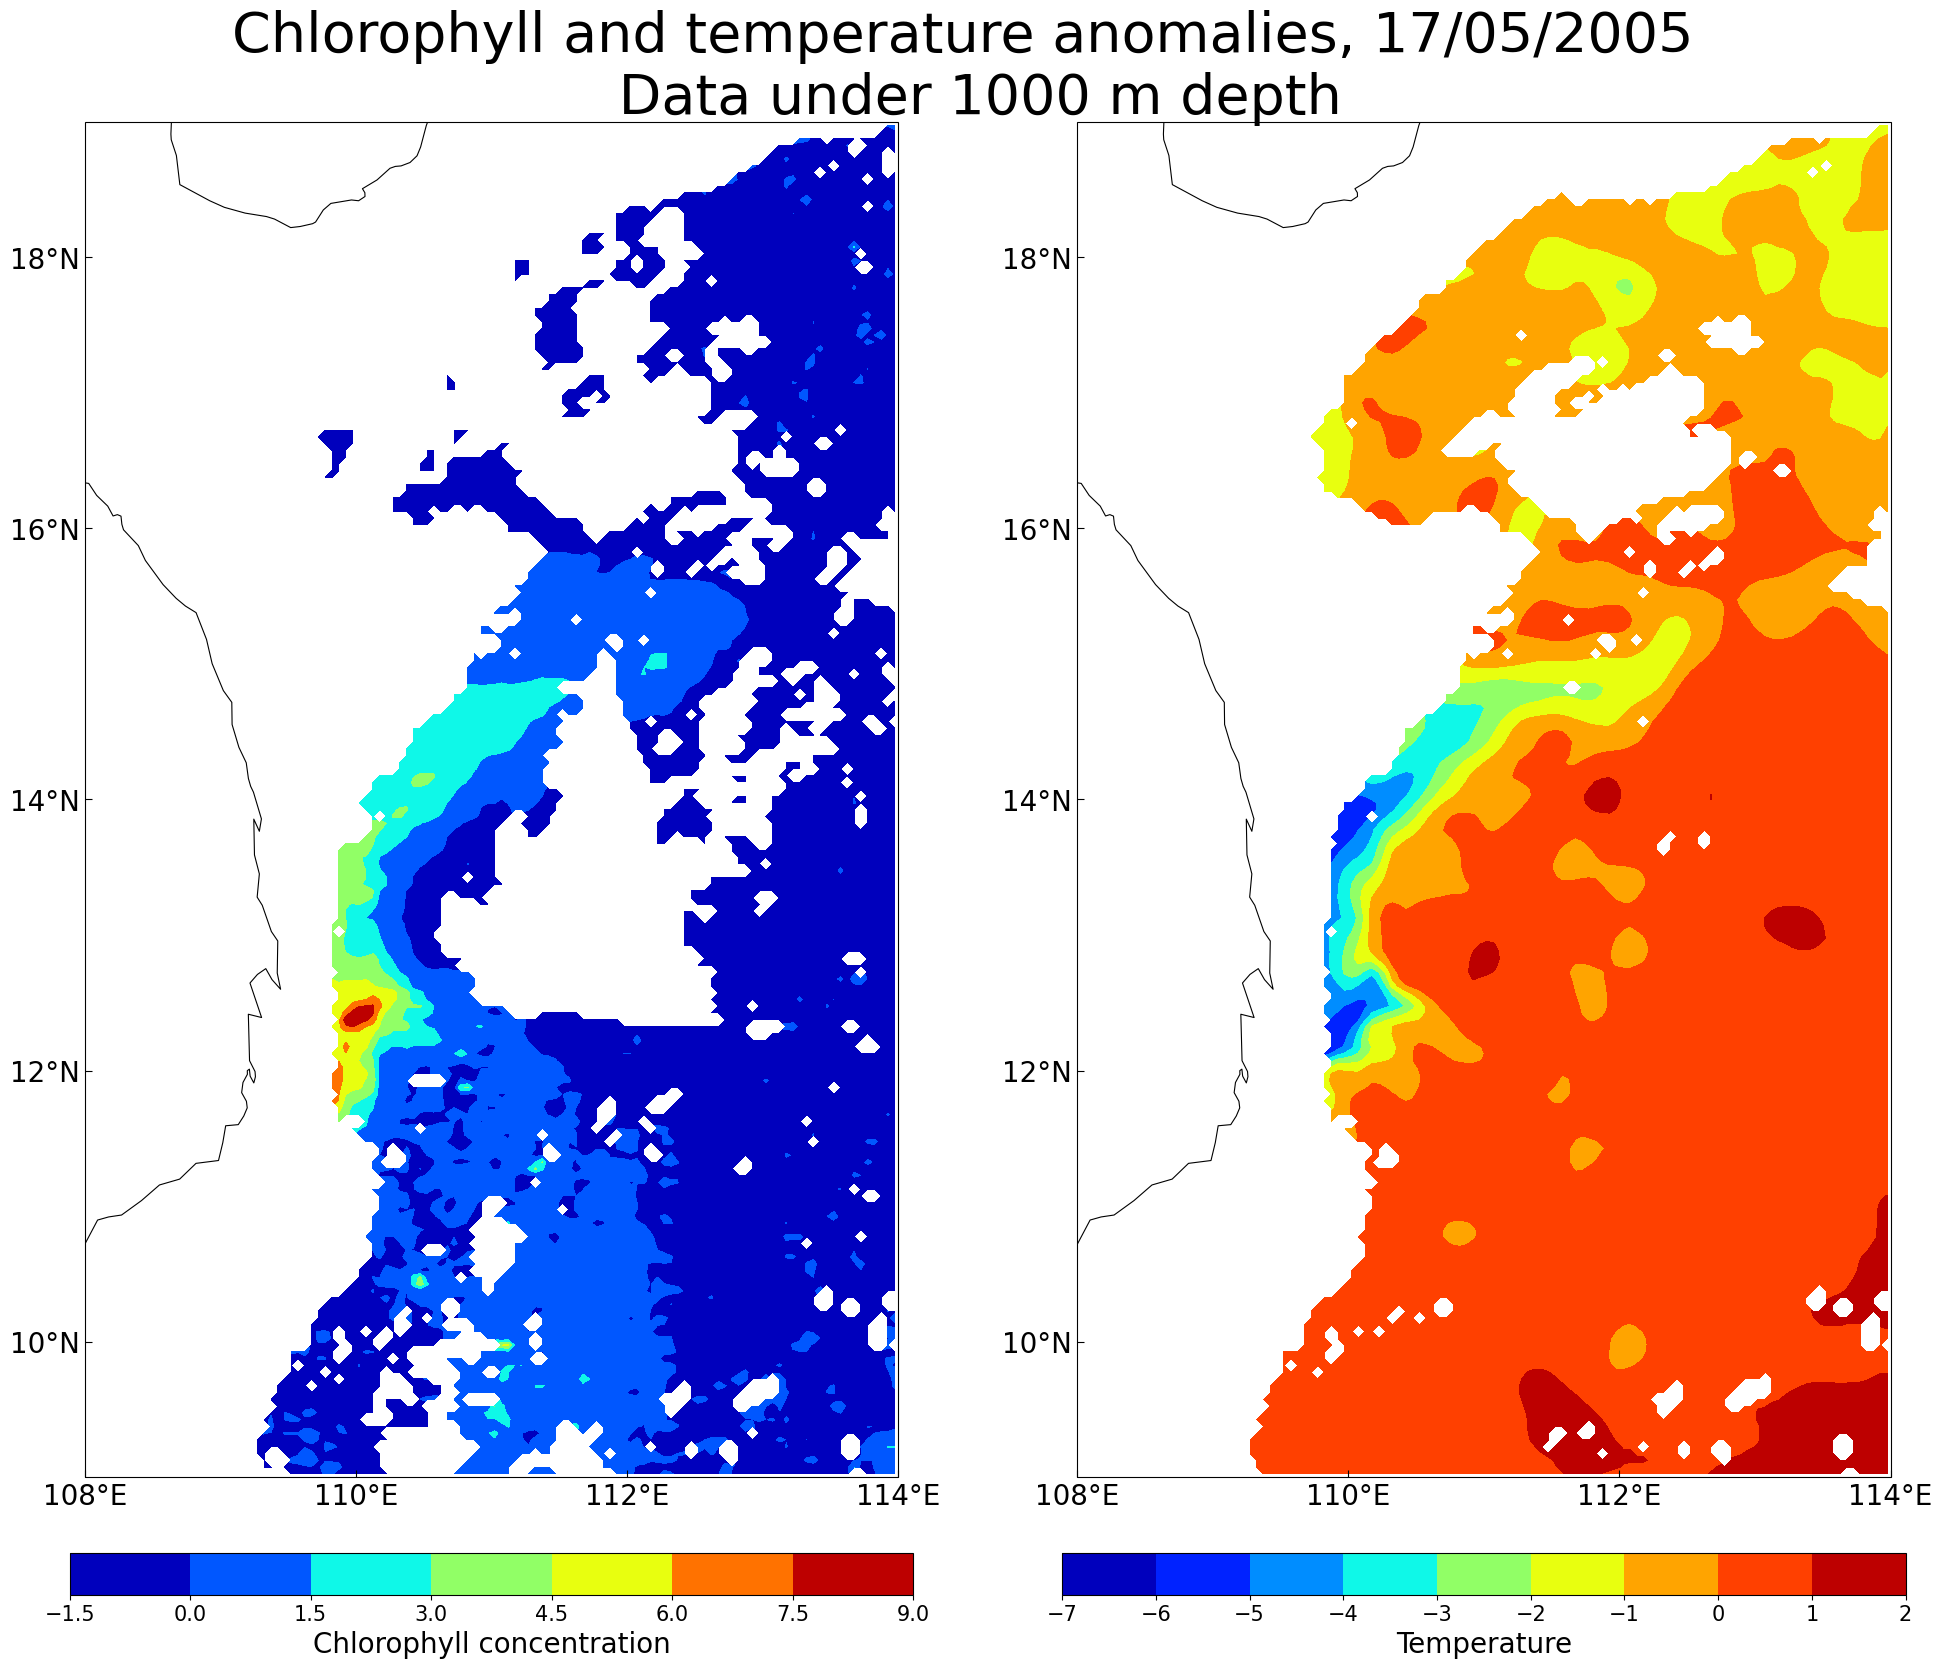

In [20]:
fig, [ax1, ax2] = plt.subplots(nrows=1, ncols=2, figsize=(20, 17), subplot_kw = {'projection' : cart_proj})


fig.suptitle("Chlorophyll and temperature anomalies, 17/05/2005 \n Data under 1000 m depth", 
             fontsize = 40)
####################################
colormap = plt.get_cmap("jet", 20) 

ax1.add_feature(states, linewidth=.5, edgecolor="black")
ax1.coastlines('50m', linewidth=0.8)

#normalize = Normalize(vmin=0.0, vmax=0.15)


a = ax1.contourf(lons, lats, chl_norm,
             transform=crs.PlateCarree(),
             cmap=colormap)

ax1.tick_params(axis = "both", direction = "in", labelsize = 20, length = 5)
ax1.set_xticks(np.arange(108,115,2), crs=crs.PlateCarree())
ax1.set_yticks(np.arange(10,20,2), crs=crs.PlateCarree())
ax1.xaxis.set_major_formatter(LONGITUDE_FORMATTER)
ax1.yaxis.set_major_formatter(LATITUDE_FORMATTER)


ax1.set_ylim([9,19])
ax1.set_xlim([108,114])

cbar = fig.colorbar(a, ax=ax1, shrink=.98, location = "bottom", fraction = 0.05, pad = 0.05)
cbar.set_label(label = "Chlorophyll concentration", fontsize = 20)
cbar.ax.tick_params(labelsize=15)

##########################
colormap = plt.get_cmap("jet", 20) 


ax2.add_feature(states, linewidth=.5, edgecolor="black")
ax2.coastlines('50m', linewidth=0.8)

#normalize = Normalize(vmin=0.0, vmax=0.15)


a = ax2.contourf(lons, lats, temp_norm,
             transform=crs.PlateCarree(),
             cmap=colormap)

ax2.tick_params(axis = "both", direction = "in", labelsize = 20, length = 5)
ax2.set_xticks(np.arange(108,115,2), crs=crs.PlateCarree())
ax2.set_yticks(np.arange(10,20,2), crs=crs.PlateCarree())
ax2.xaxis.set_major_formatter(LONGITUDE_FORMATTER)
ax2.yaxis.set_major_formatter(LATITUDE_FORMATTER)


ax2.set_ylim([9,19])
ax2.set_xlim([108,114])

cbar = fig.colorbar(a, ax=ax2, shrink=.98, location = "bottom", fraction = 0.05, pad = 0.05)
cbar.set_label(label = "Temperature", fontsize = 20)
cbar.ax.tick_params(labelsize=15)


fig.tight_layout()

plt.savefig("../immagini/SCS/chl_temp_anomalies.pdf", bbox_inches = "tight")

In [21]:
distorsions = []
for k in range(2, 15):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(data)
    distorsions.append(kmeans.inertia_)

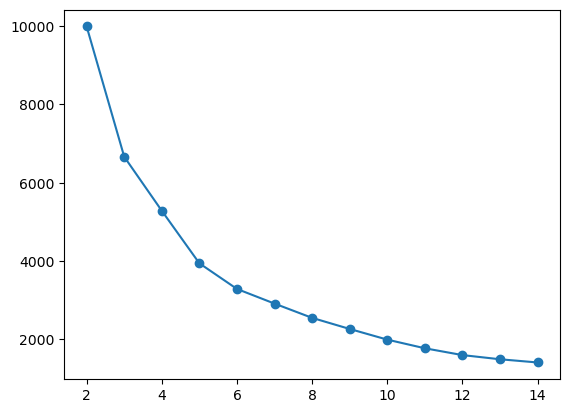

In [22]:
plt.plot(np.arange(2,15), distorsions, marker = 'o')

In [23]:
kmeans = KMeans(n_clusters = 2, init = "random")
labels = kmeans.fit_predict(data)

In [50]:
type(colormap)

matplotlib.colors.LinearSegmentedColormap

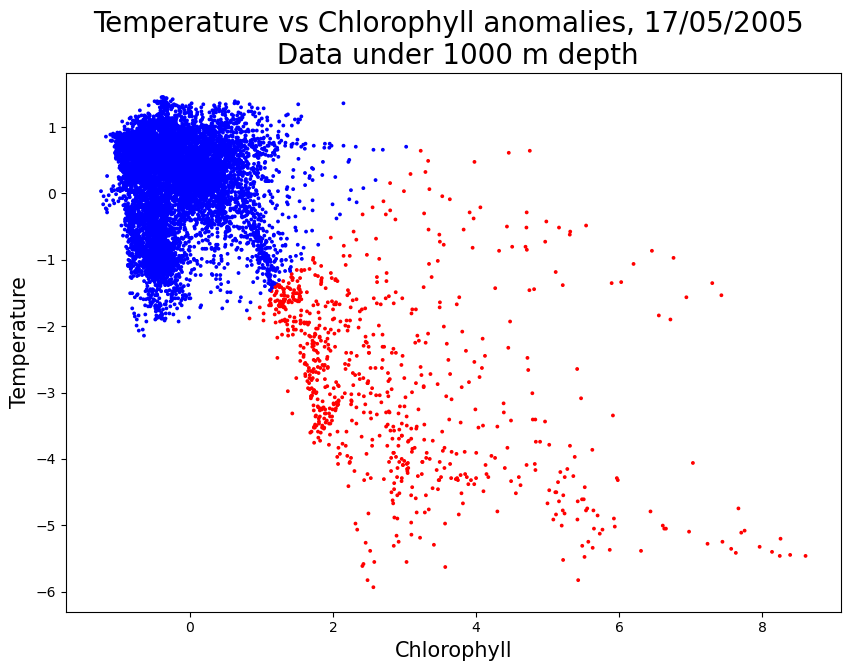

In [82]:
plt.figure(figsize = [10,7])
colormap = get_cmap("bwr_r", 2)
plt.scatter(data[:,0], data[:,1], s = 3, c = labels, cmap = colormap)
plt.xlabel("Chlorophyll", fontsize = 15)
plt.ylabel("Temperature", fontsize = 15)
plt.title("Temperature vs Chlorophyll anomalies, 17/05/2005 \n Data under 1000 m depth", fontsize = 20)

plt.savefig("../immagini/SCS/temp_chl_cluster_standardized.pdf", bbox_inches = "tight")

In [39]:
labels_matrix = np.empty(np.shape(chl_filt))
labels_matrix[:,:] = np.nan
mask = ~np.isnan(chl_norm)

labels_matrix[mask] = labels.astype(int)

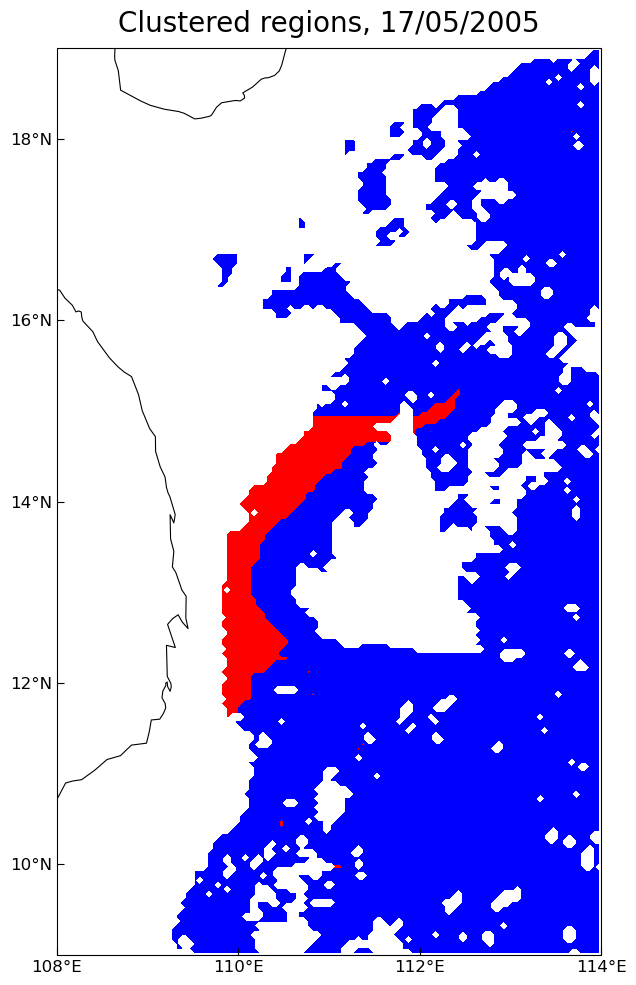

In [62]:
fig = plt.figure(figsize = [10,10])
ax = plt.axes(projection=cart_proj)

ax.add_feature(states, linewidth=.5, edgecolor="black")
ax.coastlines('50m', linewidth=0.8)

colormap = plt.get_cmap("bwr_r", 2) #or any other colormap
#normalize = Normalize(vmin=0.0, vmax=0.15)


plt.contourf(lons, lats, labels_matrix, cmap = colormap)

ax.tick_params(axis = "both", direction = "in", labelsize = 12, length = 5)
ax.set_xticks(np.arange(108,115,2), crs=crs.PlateCarree())
ax.set_yticks(np.arange(10,20,2), crs=crs.PlateCarree())
ax.xaxis.set_major_formatter(LONGITUDE_FORMATTER)
ax.yaxis.set_major_formatter(LATITUDE_FORMATTER)


ax.set_ylim([9,19])
ax.set_xlim([108,114])

fig.suptitle("Clustered regions, 17/05/2005", fontsize = 20)
fig.tight_layout()

plt.savefig("../immagini/SCS/clustered_regions.pdf", bbox_inches = "tight")
#cbar.set_label(label = "Chlorophyll concentration [mg m$^{-3}$]", fontsize = 15)

## Rimozione della media settimanale

In [33]:
fname = "../data/SCS/CMEMS_chl.nc"
chl_data = xr.open_dataset(fname)

fname = "../data/SCS/CMEMS_temp.nc"
temp_data = xr.open_dataset(fname)

bath =  xr.open_dataset("../data/SCS/bathymetry.nc")

In [45]:
## Select a single date (relative to SCS paper, figure 1)
date = "2005-05-17"

chl = chl_data.sel(time=date).CHL#.to_numpy()
#lons_chl = chl_data.sel(time=date).lon.to_numpy()
#lats_chl = chl_data.sel(time=date).lat.to_numpy()

date = "2005-05-17T12:00:00"

temp = temp_data.sel(time=date).analysed_sst.to_numpy()

lons = temp_data.sel(time=date).lon#.to_numpy()
lats = temp_data.sel(time=date).lat#.to_numpy()

chl = chl.interp(lon = lons, lat = lats, method = "nearest").to_numpy()

In [47]:
days_list = ["2005-05-"+str(i)+"T12:00:00" for i in range(14,22)]

temp_week = temp_data.sel(time=days_list).analysed_sst.to_numpy()

lons = temp_data.sel(time=days_list).lon#.to_numpy()
lats = temp_data.sel(time=days_list).lat#.to_numpy()

days_list = ["2005-05-"+str(i) for i in range(14,22)]

chl_week = chl_data.sel(time=days_list).CHL

chl_week = chl_week.interp(lon = lons, lat = lats, method = "nearest").to_numpy()

In [48]:
#Uniformazione della batimetria con la griglia meno fitta (temperatura)
elevation = bath.elevation.interp(lon = lons, lat = lats, method = "nearest").to_numpy()
elevation[np.isnan(elevation)] = 0

In [49]:
for (i, ch) in enumerate(chl_week):

    print("percentuale di nan per ", days_list[i], len(ch[np.isnan(ch)].flatten())/len(ch.flatten()))

percentuale di nan per  2005-05-14 0.5494839850335101
percentuale di nan per  2005-05-15 0.18699888984827925
percentuale di nan per  2005-05-16 0.3190658278853666
percentuale di nan per  2005-05-17 0.3511368775954936
percentuale di nan per  2005-05-18 0.23403642942313227
percentuale di nan per  2005-05-19 0.37333991201019695
percentuale di nan per  2005-05-20 0.4002302536902266
percentuale di nan per  2005-05-21 0.23502323095267463


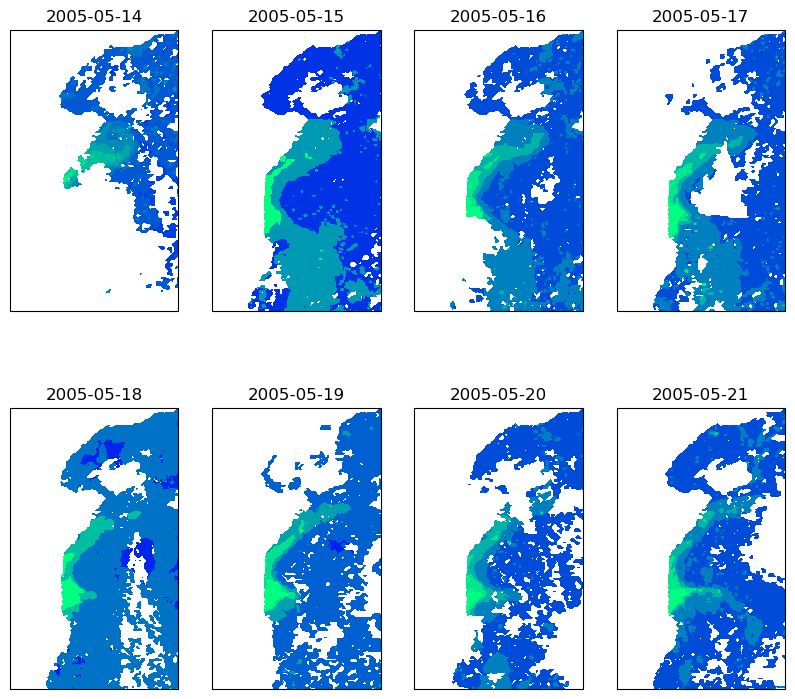

In [50]:
fig, axs = plt.subplots(figsize = [10,9],
                        nrows = 2, ncols = 4, subplot_kw = dict(projection=crs.PlateCarree()))

axs = axs.ravel()

norm = Normalize(vmin = 0., vmax = 0.20)
for (i, ch) in enumerate(chl_week):
    ch[elevation >= -1000] = np.nan
    axs[i].contourf(lons, lats, ch, cmap = "winter", norm = norm)
    axs[i].set_title(days_list[i])

In [51]:
chl_week[:,elevation >= -1000] = np.nan 
chl_mean = np.nanmean(chl_week, axis = 0)
chl_norm = (chl_mean - np.nanmean(chl_mean))/np.nanstd(chl_mean)

temp_week[:, elevation >= -1000] = np.nan
temp_mean = np.nanmean(temp_week, axis = 0)
temp_norm = (temp_mean - np.nanmean(temp_mean))/np.nanstd(temp_mean)

C:\Users\feder\AppData\Local\Temp\ipykernel_16300\4269276643.py:2: RuntimeWarning: Mean of empty slice
  chl_mean = np.nanmean(chl_week, axis = 0)
C:\Users\feder\AppData\Local\Temp\ipykernel_16300\4269276643.py:6: RuntimeWarning: Mean of empty slice
  temp_mean = np.nanmean(temp_week, axis = 0)


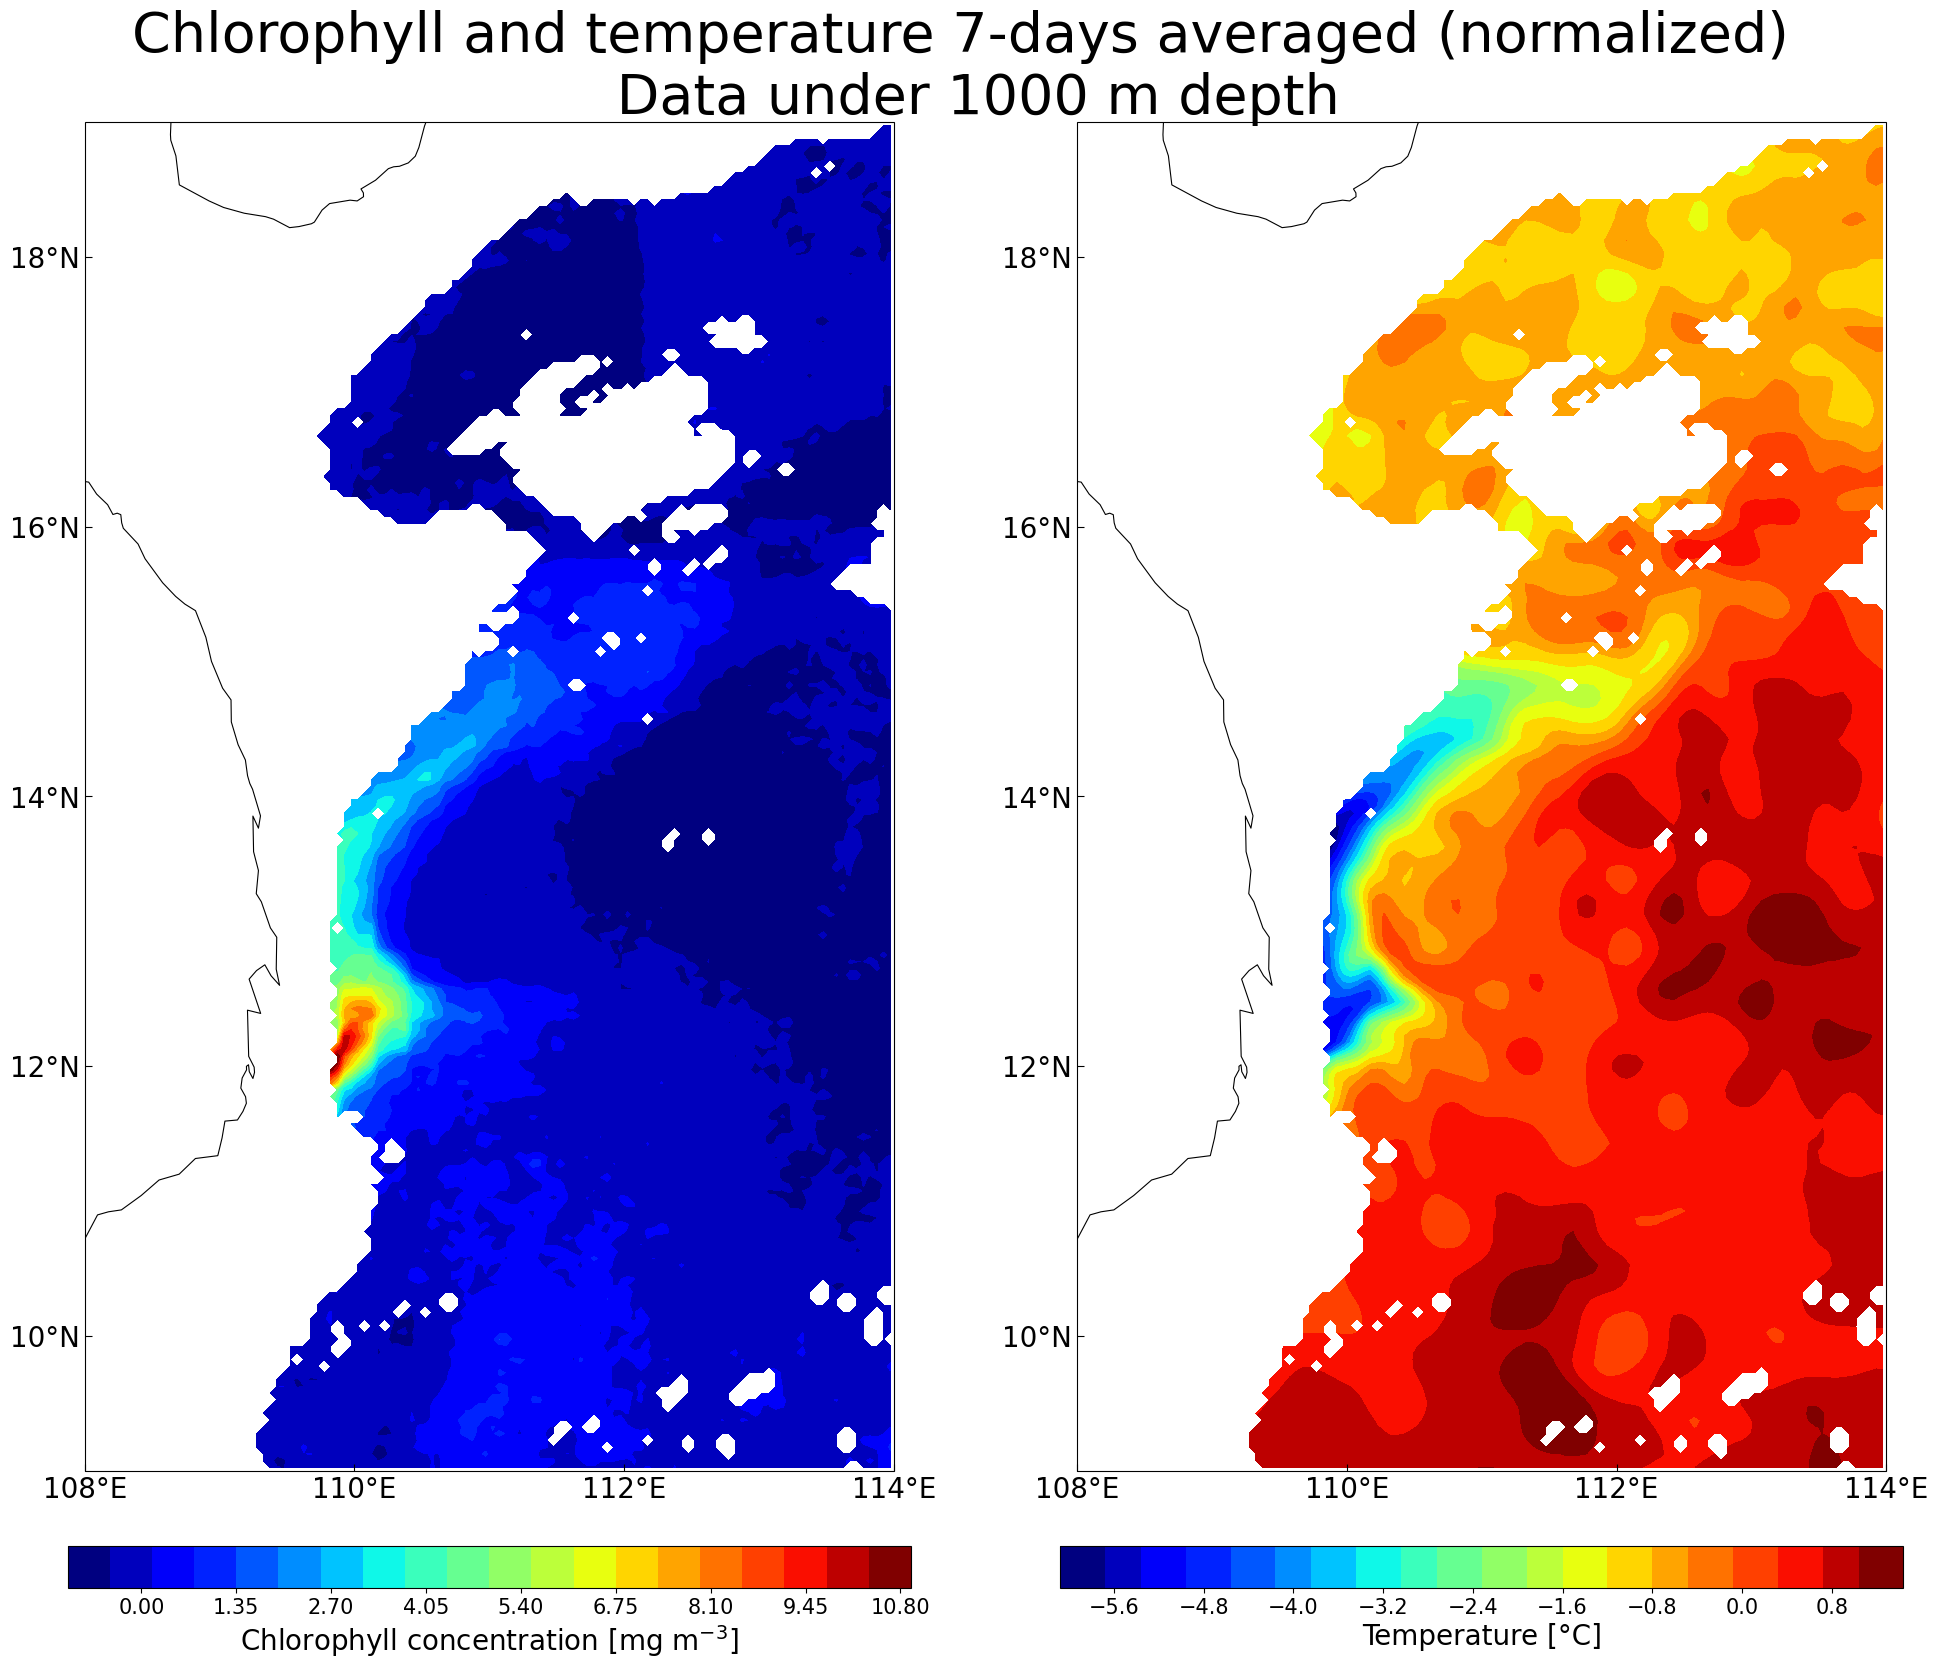

In [52]:
fig, [ax1, ax2] = plt.subplots(nrows=1, ncols=2, figsize=(20, 17), subplot_kw = {'projection' : cart_proj})

colormap = plt.get_cmap("jet", 20) #or any other colormap

fig.suptitle("Chlorophyll and temperature 7-days averaged (normalized) \n Data under 1000 m depth", 
             fontsize = 40)
####################################
ax1.add_feature(states, linewidth=.5, edgecolor="black")
ax1.coastlines('50m', linewidth=0.8)

#normalize = Normalize(vmin=0.0, vmax=0.15)


a = ax1.contourf(lons, lats, chl_norm, 100,
             transform=crs.PlateCarree(),
             cmap=colormap)

ax1.tick_params(axis = "both", direction = "in", labelsize = 20, length = 5)
ax1.set_xticks(np.arange(108,115,2), crs=crs.PlateCarree())
ax1.set_yticks(np.arange(10,20,2), crs=crs.PlateCarree())
ax1.xaxis.set_major_formatter(LONGITUDE_FORMATTER)
ax1.yaxis.set_major_formatter(LATITUDE_FORMATTER)


ax1.set_ylim([9,19])
ax1.set_xlim([108,114])

cbar = fig.colorbar(a, ax=ax1, shrink=.98, location = "bottom", fraction = 0.05, pad = 0.05)
cbar.set_label(label = "Chlorophyll concentration [mg m$^{-3}$]", fontsize = 20)
cbar.ax.tick_params(labelsize=15)

##########################

ax2.add_feature(states, linewidth=.5, edgecolor="black")
ax2.coastlines('50m', linewidth=0.8)

#normalize = Normalize(vmin=0.0, vmax=0.15)


a = ax2.contourf(lons, lats, temp_norm, 100,
             transform=crs.PlateCarree(),
             cmap=colormap)

ax2.tick_params(axis = "both", direction = "in", labelsize = 20, length = 5)
ax2.set_xticks(np.arange(108,115,2), crs=crs.PlateCarree())
ax2.set_yticks(np.arange(10,20,2), crs=crs.PlateCarree())
ax2.xaxis.set_major_formatter(LONGITUDE_FORMATTER)
ax2.yaxis.set_major_formatter(LATITUDE_FORMATTER)


ax2.set_ylim([9,19])
ax2.set_xlim([108,114])

cbar = fig.colorbar(a, ax=ax2, shrink=.98, location = "bottom", fraction = 0.05, pad = 0.05)
cbar.set_label(label = "Temperature [°C]", fontsize = 20)
cbar.ax.tick_params(labelsize=15)


fig.tight_layout()

#plt.savefig("./data/SCS/chl_temp_anomalies.pdf", bbox_inches = "tight")

In [53]:
data = np.array(list(zip(chl_norm[~np.isnan(chl_norm)], temp_norm[~np.isnan(chl_norm)])))

In [54]:
kmeans = KMeans(n_clusters = 2, init = "random")
labels = kmeans.fit_predict(data)

Text(0.5, 1.0, 'Temperature vs Chlorophyll (standardized), 17/05/2005 \n Data under 1000 m depth')

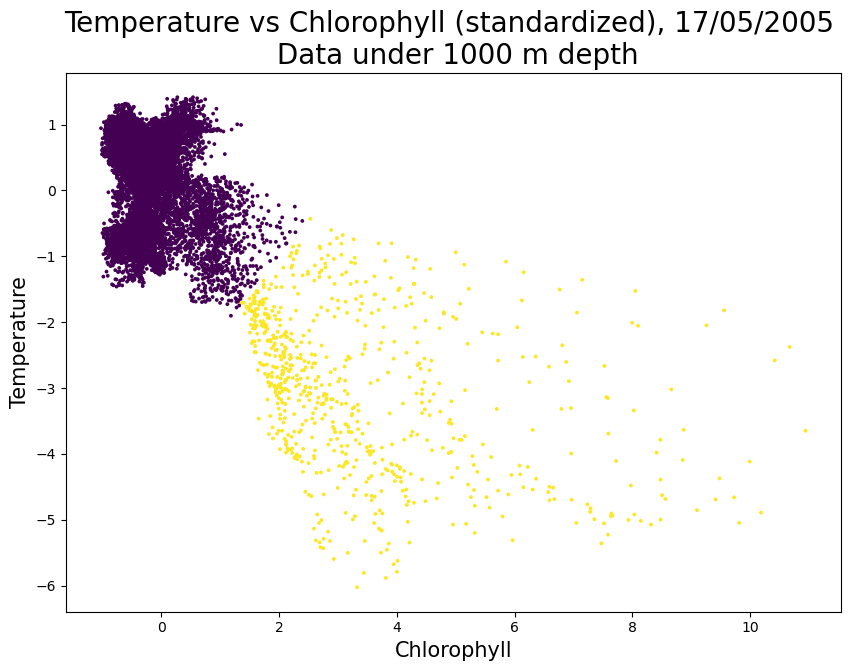

In [55]:
plt.figure(figsize = [10,7])
plt.scatter(data[:,0], data[:,1], s = 3, c = labels)
plt.xlabel("Chlorophyll", fontsize = 15)
plt.ylabel("Temperature", fontsize = 15)
plt.title("Temperature vs Chlorophyll (standardized), 17/05/2005 \n Data under 1000 m depth", fontsize = 20)

#plt.savefig("./data/SCS/temp_chl_cluster_standardized.pdf", bbox_inches = "tight")

In [56]:
labels_matrix = np.empty(np.shape(chl_filt))
labels_matrix[:,:] = np.nan
mask = ~np.isnan(chl_norm)

labels_matrix[mask] = labels.astype(int)

FileNotFoundError: [Errno 2] No such file or directory: './data/SCS/clustered_regions.pdf'

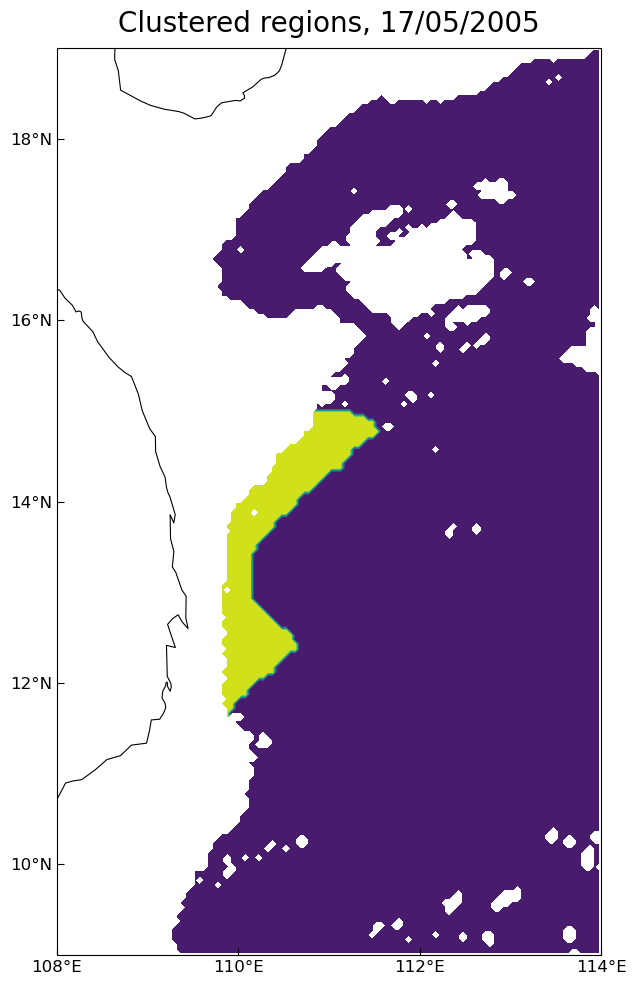

In [57]:
fig = plt.figure(figsize = [10,10])
ax = plt.axes(projection=cart_proj)

ax.add_feature(states, linewidth=.5, edgecolor="black")
ax.coastlines('50m', linewidth=0.8)

colormap = plt.get_cmap("jet", 4) #or any other colormap
#normalize = Normalize(vmin=0.0, vmax=0.15)


plt.contourf(lons, lats, labels_matrix)

ax.tick_params(axis = "both", direction = "in", labelsize = 12, length = 5)
ax.set_xticks(np.arange(108,115,2), crs=crs.PlateCarree())
ax.set_yticks(np.arange(10,20,2), crs=crs.PlateCarree())
ax.xaxis.set_major_formatter(LONGITUDE_FORMATTER)
ax.yaxis.set_major_formatter(LATITUDE_FORMATTER)


ax.set_ylim([9,19])
ax.set_xlim([108,114])

fig.suptitle("Clustered regions, 17/05/2005", fontsize = 20)
fig.tight_layout()

plt.savefig("./data/SCS/clustered_regions.pdf", bbox_inches = "tight")
#cbar.set_label(label = "Chlorophyll concentration [mg m$^{-3}$]", fontsize = 15)